# 팀프로젝트 Week3 ‒ 모두의 주차장 앱 이용자 별 향후 이용건수 예측
§ 주제
- 앱 이용자 별 향후 이용 건수 예측
§ Task 정의
- Regression, 유저 별 한 달 후 이용 건수 예측
§ Metric 정의
- MSE, MAE

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


In [84]:
import pandas as pd
import numpy as np
import math

from matplotlib import font_manager, rc
import seaborn as sns
import platform
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go 
import plotly.io as pio
pio.renderers.default = "notebook_connected"
if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

In [85]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/실전db.csv")
data

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR
...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J


# EDA
### USER_ID, JOIN_DATE, D_TYPE, STORE_ID, GOODS_TYPE, DATE, COUNT, AD1

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   USER_ID     879271 non-null  int64 
 1   JOIN_DATE   879271 non-null  object
 2   D_TYPE      879271 non-null  object
 3   STORE_ID    879271 non-null  int64 
 4   GOODS_TYPE  879271 non-null  object
 5   DATE        879271 non-null  object
 6   COUNT       879271 non-null  int64 
 7   AD1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB


In [87]:
data.isna().sum()

# 결측치 x

USER_ID       0
JOIN_DATE     0
D_TYPE        0
STORE_ID      0
GOODS_TYPE    0
DATE          0
COUNT         0
AD1           0
dtype: int64

In [88]:
data.USER_ID.value_counts()

# USER_ID의 유니크 값은 165425

999665     366
591610     244
1355841    235
1407916    222
1224426    222
          ... 
586251       1
1575444      1
1573397      1
1591836      1
30735        1
Name: USER_ID, Length: 165425, dtype: int64

In [89]:
data.JOIN_DATE.sort_values()

# 이상하게 오래된 날짜가 존재함을 확인

176320    1970-01-01
625539    1970-01-01
226658    1970-01-01
226415    1970-01-01
226042    1970-01-01
             ...    
879214    2020-12-31
879213    2020-12-31
879212    2020-12-31
879230    2020-12-31
879270    2020-12-31
Name: JOIN_DATE, Length: 879271, dtype: object

In [108]:
print(sorted(data.JOIN_DATE.unique())[:5])
print(sorted(data.JOIN_DATE.unique())[-5:])

# 1970-01-01만 떨어져있는 것은 결측치를 수정 or 특수한 경우라고 판단된다.

['1970-01-01', '2013-12-16', '2013-12-17', '2013-12-18', '2013-12-21']
['2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-31']


In [91]:
data.D_TYPE.value_counts()

# D_TYPE의 의미를 모르겠음.

AA    493166
BB    384541
CC      1564
Name: D_TYPE, dtype: int64

In [92]:
data.STORE_ID.value_counts()

# 주차장 주소에 대한 ID로, 갯수는 1061

220557    17617
220893    17220
220655    16275
220848    15935
92437     15866
          ...  
230996        1
230216        1
223665        1
223066        1
225629        1
Name: STORE_ID, Length: 1061, dtype: int64

In [93]:
data.GOODS_TYPE.value_counts()

# 상품 타입인데 구체적으론 모르겠음.

A    609790
C    131163
B    118541
D     19777
Name: GOODS_TYPE, dtype: int64

In [109]:
print(sorted(data.DATE.unique())[:5])
print(sorted(data.DATE.unique())[-5:])

# 2020년 데이터

['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05']
['2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-31']


In [95]:
data.COUNT.value_counts()

# 이용횟수 같음. 1 ~ 61
# 유저ID에 부여되는 것인지 유저ID와 장소ID에 부여되는것인지 모름

1     863775
2      13519
3       1061
4        271
5        136
6         66
7         45
9         25
16        21
12        21
8         20
13        19
14        19
15        19
28        17
10        16
11        15
17        15
23        15
21        14
18        14
25        14
19        13
22         9
32         9
26         9
27         7
24         7
30         7
31         7
34         7
29         6
20         6
36         5
40         4
37         3
39         3
38         3
46         3
49         3
35         3
42         2
43         2
33         2
50         2
47         2
55         1
53         1
51         1
58         1
41         1
48         1
45         1
44         1
59         1
61         1
Name: COUNT, dtype: int64

In [96]:
data[data.COUNT == 61]

# COUNT가 61인 데이터

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
729776,999665,2018-12-16,CC,96266,A,2020-11-07,61,GN


In [97]:
data[data.USER_ID == 999665]

# COUNT가 유저의 결제횟수는 아님

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
372,999665,2018-12-16,CC,82399,A,2020-01-01,6,JRR
1527,999665,2018-12-16,CC,104988,A,2020-01-02,11,GN
3121,999665,2018-12-16,CC,181832,A,2020-01-03,7,SC
5034,999665,2018-12-16,CC,109223,A,2020-01-04,28,MP
6919,999665,2018-12-16,CC,104916,A,2020-01-05,14,GN
...,...,...,...,...,...,...,...,...
867260,999665,2018-12-16,CC,2428,A,2020-12-27,17,CY
868847,999665,2018-12-16,CC,109267,A,2020-12-28,24,J
871562,999665,2018-12-16,CC,90193,C,2020-12-29,23,GW
874317,999665,2018-12-16,CC,220797,D,2020-12-30,40,GS


In [98]:
data[(data.USER_ID == 999665) & (data.STORE_ID == 96266)]

# 한 유저의 같은 장소 결제내역도 아님

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
573260,999665,2018-12-16,CC,96266,A,2020-09-12,27,GN
596546,999665,2018-12-16,CC,96266,A,2020-09-21,28,GN
729776,999665,2018-12-16,CC,96266,A,2020-11-07,61,GN


In [99]:
data[data.USER_ID == 999665].sort_values(by = "COUNT")

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
87880,999665,2018-12-16,CC,1109,A,2020-02-19,3,JRR
47633,999665,2018-12-16,CC,219936,A,2020-01-29,5,YD
85921,999665,2018-12-16,CC,2085,A,2020-02-18,5,YD
95852,999665,2018-12-16,CC,173209,A,2020-02-23,5,J
372,999665,2018-12-16,CC,82399,A,2020-01-01,6,JRR
...,...,...,...,...,...,...,...,...
767392,999665,2018-12-16,CC,131081,A,2020-11-19,53,YO
726277,999665,2018-12-16,CC,190055,A,2020-11-06,55,SB
751974,999665,2018-12-16,CC,1109,A,2020-11-14,58,JRR
748372,999665,2018-12-16,CC,109677,A,2020-11-13,59,JRR


In [100]:
data[data.STORE_ID == 96266].sort_values(by = "COUNT")

# 한 장소의 결제 내역도 아님

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
226,789085,2018-04-26,AA,96266,A,2020-01-01,1,GN
634933,1714857,2020-10-05,AA,96266,A,2020-10-06,1,GN
635066,91394,2015-05-23,BB,96266,A,2020-10-07,1,GN
635209,451078,2017-01-21,BB,96266,A,2020-10-07,1,GN
635245,494279,2017-04-04,AA,96266,A,2020-10-07,1,GN
...,...,...,...,...,...,...,...,...
434927,860133,2018-07-17,AA,96266,A,2020-07-21,3,GN
51534,978417,2018-11-24,AA,96266,A,2020-01-31,4,GN
573260,999665,2018-12-16,CC,96266,A,2020-09-12,27,GN
596546,999665,2018-12-16,CC,96266,A,2020-09-21,28,GN


In [101]:
data[(data.DATE == "2020-11-07") & (data.STORE_ID == 96266)]

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
728864,194706,2015-11-14,BB,96266,A,2020-11-07,1,GN
729255,655372,2017-11-21,AA,96266,A,2020-11-07,1,GN
729461,806427,2018-05-16,BB,96266,A,2020-11-07,1,GN
729594,891363,2018-08-17,AA,96266,A,2020-11-07,1,GN
729638,917754,2018-09-15,BB,96266,A,2020-11-07,1,GN
729776,999665,2018-12-16,CC,96266,A,2020-11-07,61,GN
729900,1078056,2019-02-26,BB,96266,A,2020-11-07,1,GN
730114,1190819,2019-06-07,BB,96266,A,2020-11-07,1,GN
730198,1233489,2019-07-13,BB,96266,A,2020-11-07,1,GN
730261,1264773,2019-08-06,BB,96266,A,2020-11-07,1,GN


In [102]:
data.AD1.value_counts()

# AD1의 의미도 모르겠음

J      179383
GN     172967
JRR    126586
SC      75856
MP      67819
        ...  
ADS         1
VO          1
NW          1
DY          1
GR          1
Name: AD1, Length: 85, dtype: int64

In [103]:
data[data.USER_ID == 999665].D_TYPE.unique()

array(['CC'], dtype=object)

In [104]:
data[data.USER_ID == 999665]

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
372,999665,2018-12-16,CC,82399,A,2020-01-01,6,JRR
1527,999665,2018-12-16,CC,104988,A,2020-01-02,11,GN
3121,999665,2018-12-16,CC,181832,A,2020-01-03,7,SC
5034,999665,2018-12-16,CC,109223,A,2020-01-04,28,MP
6919,999665,2018-12-16,CC,104916,A,2020-01-05,14,GN
...,...,...,...,...,...,...,...,...
867260,999665,2018-12-16,CC,2428,A,2020-12-27,17,CY
868847,999665,2018-12-16,CC,109267,A,2020-12-28,24,J
871562,999665,2018-12-16,CC,90193,C,2020-12-29,23,GW
874317,999665,2018-12-16,CC,220797,D,2020-12-30,40,GS


In [105]:
data[data.USER_ID == 591610]

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
1114,591610,2017-08-31,AA,220719,A,2020-01-02,1,JRR
4439,591610,2017-08-31,AA,182320,A,2020-01-04,1,JRR
7993,591610,2017-08-31,AA,220719,A,2020-01-06,1,JRR
9479,591610,2017-08-31,AA,1109,A,2020-01-07,1,JRR
11102,591610,2017-08-31,AA,92264,C,2020-01-08,1,JRR
...,...,...,...,...,...,...,...,...
782594,591610,2017-08-31,AA,1109,A,2020-11-24,1,JRR
785424,591610,2017-08-31,AA,1109,A,2020-11-25,1,JRR
798551,591610,2017-08-31,AA,1109,A,2020-11-30,1,JRR
801326,591610,2017-08-31,AA,1109,A,2020-12-01,1,JRR


In [106]:
data[data.USER_ID == 591610].sort_values('COUNT')

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
1114,591610,2017-08-31,AA,220719,A,2020-01-02,1,JRR
471786,591610,2017-08-31,AA,947,C,2020-08-03,1,JRR
474634,591610,2017-08-31,AA,92264,A,2020-08-04,1,JRR
477516,591610,2017-08-31,AA,92264,A,2020-08-05,1,JRR
480445,591610,2017-08-31,AA,92264,A,2020-08-06,1,JRR
...,...,...,...,...,...,...,...,...
255589,591610,2017-08-31,AA,1109,A,2020-05-11,1,JRR
257793,591610,2017-08-31,AA,1109,A,2020-05-12,1,JRR
260016,591610,2017-08-31,AA,1109,A,2020-05-13,1,JRR
809459,591610,2017-08-31,AA,1109,A,2020-12-04,1,JRR


# COUNT == 시간?

## 목표
    1. 주차시간(COUNT)에 대한 EDA
    2. 요일별 이용량 EDA
    3. 주차시간 예측

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   USER_ID     879271 non-null  int64 
 1   JOIN_DATE   879271 non-null  object
 2   D_TYPE      879271 non-null  object
 3   STORE_ID    879271 non-null  int64 
 4   GOODS_TYPE  879271 non-null  object
 5   DATE        879271 non-null  object
 6   COUNT       879271 non-null  int64 
 7   AD1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB


           USER_ID  STORE_ID     COUNT
USER_ID   1.000000  0.041623 -0.004571
STORE_ID  0.041623  1.000000 -0.004013
COUNT    -0.004571 -0.004013  1.000000


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


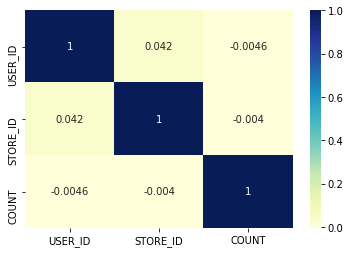

In [27]:
print(data.corr())
sns.heatmap(data = data.corr(), annot = True, cmap="YlGnBu")

# int형 변수인 USER_ID, STORE_ID는 COUNT와 상관관계가 없다.

In [28]:
sorted(data.JOIN_DATE.unique())[:5]

['1970-01-01', '2013-12-16', '2013-12-17', '2013-12-18', '2013-12-21']

In [29]:
sorted(data.JOIN_DATE.unique())[-5:]

['2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-31']

In [30]:
data['JOIN_YEAR'] = data["JOIN_DATE"].apply(lambda x: x[:4])
data

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,JOIN_YEAR
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014
...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020


In [31]:
data['JOIN_MONTH'] = data["JOIN_DATE"].apply(lambda x: x[5:7])
data

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,JOIN_YEAR,JOIN_MONTH
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014,01
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014,02
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014,11
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014,12
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014,12
...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020,12
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020,12
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020,12
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020,12


In [32]:
data['MONTH'] = data["DATE"].apply(lambda x: x[5:7])
data

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,JOIN_YEAR,JOIN_MONTH,MONTH
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014,01,01
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014,02,01
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014,11,01
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014,12,01
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014,12,01
...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020,12,12
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020,12,12
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020,12,12
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020,12,12


In [33]:
from datetime import datetime

data['WEEKDAY'] = data["DATE"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').weekday())
data

# 0:월, 1:화, 2:수, 3:목, 4:금, 5:토, 6:일

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,JOIN_YEAR,JOIN_MONTH,MONTH,WEEKDAY
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014,01,01,2
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014,02,01,2
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014,11,01,2
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014,12,01,2
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014,12,01,2
...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020,12,12,3
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020,12,12,3
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020,12,12,3
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020,12,12,3


In [34]:
data['JOIN_YM'] = data["JOIN_DATE"].apply(lambda x: x[:7])
data

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,JOIN_YEAR,JOIN_MONTH,MONTH,WEEKDAY,JOIN_YM
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014,01,01,2,2014-01
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014,02,01,2,2014-02
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014,11,01,2,2014-11
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014,12,01,2,2014-12
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014,12,01,2,2014-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020,12,12,3,2020-12
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020,12,12,3,2020-12
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020,12,12,3,2020-12
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020,12,12,3,2020-12


## Cohort

,USER_ID
JOIN_YM,
1970-01,264
2013-12,9
2014-01,14
2014-02,9
2014-03,10
...,...
2020-08,7113
2020-09,6478
2020-10,7571


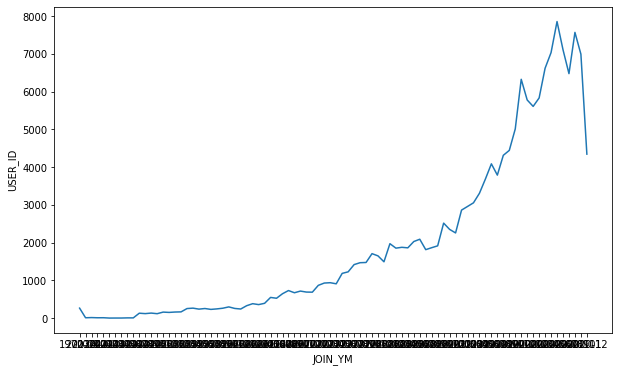

In [35]:
tmp = data[["USER_ID", "JOIN_YM"]].drop_duplicates().groupby('JOIN_YM').count()
display(tmp)

plt.figure(figsize = (10,6))
sns.lineplot(data=tmp.reset_index(), x = "JOIN_YM", y='USER_ID')

,USER_ID
JOIN_YEAR,
1970,264
2013,9
2014,549
2015,2679
2016,5796
2017,13500
2018,22936
2019,42124
2020,77568


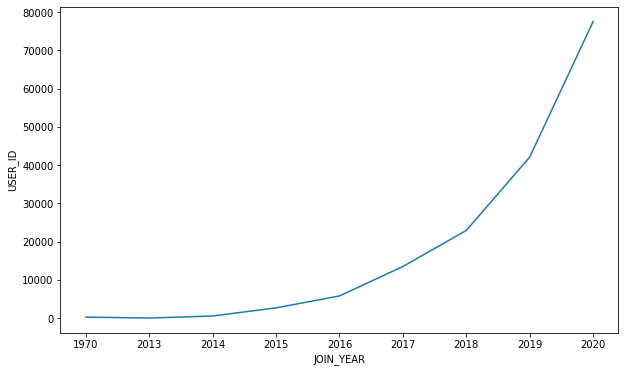

In [36]:
# 결제 내역 중 가입자 년도별 사용자 수

tmp = data[["USER_ID", "JOIN_YEAR"]].drop_duplicates().groupby('JOIN_YEAR').count()
display(tmp)

plt.figure(figsize = (10,6))
sns.lineplot(data=tmp.reset_index(), x = "JOIN_YEAR", y='USER_ID')

,USER_ID
JOIN_MONTH,
01,11711
02,10617
03,11812
04,12123
05,13103
06,13773
07,15550
08,15303
09,14506


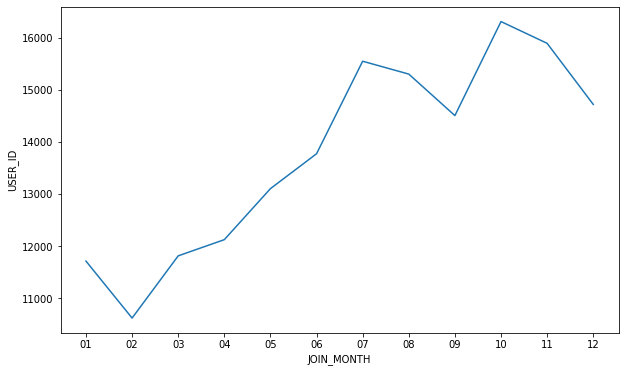

In [37]:
# 가입 월에 따른 사용자 수

tmp = data[["USER_ID", "JOIN_MONTH"]].drop_duplicates().groupby('JOIN_MONTH').count()
display(tmp)

plt.figure(figsize = (10,6))
sns.lineplot(data=tmp.reset_index(), x = "JOIN_MONTH", y='USER_ID')

USER_ID
JOIN_YEAR JOIN_MONTH         
1970      01              264
2013      12                9
2014      01               14
          02                9
          03               10
...                       ...
2020      08             7113
          09             6478
          10             7571
          11             6994
          12             4345

[86 rows x 1 columns]

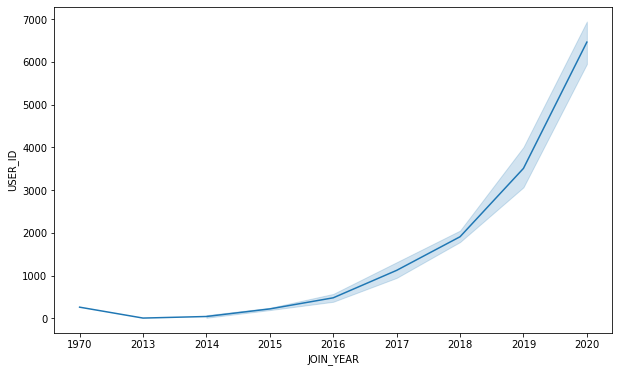

In [38]:
# 년도별 가입자수

tmp = data[["USER_ID", "JOIN_YEAR", "JOIN_MONTH"]].drop_duplicates().groupby(['JOIN_YEAR', "JOIN_MONTH"]).count()
display(tmp)

plt.figure(figsize = (10,6))
sns.lineplot(data=tmp.reset_index(), x = 'JOIN_YEAR', y = 'USER_ID')

주차시간(COUNT)에 대한 EDA

In [39]:
data

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,JOIN_YEAR,JOIN_MONTH,MONTH,WEEKDAY,JOIN_YM
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014,01,01,2,2014-01
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014,02,01,2,2014-02
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014,11,01,2,2014-11
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014,12,01,2,2014-12
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014,12,01,2,2014-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020,12,12,3,2020-12
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020,12,12,3,2020-12
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020,12,12,3,2020-12
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020,12,12,3,2020-12


In [40]:
# 가입 년도별 주차시간 평균

data.groupby("JOIN_YEAR").mean()[["COUNT"]]

# 연관성 없음.

,COUNT
JOIN_YEAR,
1970,1.023788
2013,1.027027
2014,1.015556
2015,1.022615
2016,1.018165
2017,1.017739
2018,1.072493
2019,1.018983
2020,1.023086


In [41]:
# 가입 월별 주차시간 평균

data.groupby("JOIN_MONTH").mean()[["COUNT"]]
# 12월만 좀 높은데 이상치가 있을거라고 추측된다.

,COUNT
JOIN_MONTH,
01,1.021383
02,1.017256
03,1.021240
04,1.018408
05,1.018712
06,1.019757
07,1.021459
08,1.022922
09,1.023021


In [42]:
# D_TYPE별 주차시간 평균

data.groupby("D_TYPE").mean()[["COUNT"]]
# CC만 유독 높은 수치를 보여준다.

,COUNT
D_TYPE,
AA,1.021920
BB,1.018617
CC,5.858696


In [43]:
# 월별 주차시간 평균

data.groupby("MONTH").mean()[["COUNT"]]
# 눈에 띄는 특징은 없음. 하반기에 약간 높은 정도?

,COUNT
MONTH,
01,1.025928
02,1.024406
03,1.023414
04,1.023074
05,1.026145
06,1.026143
07,1.028553
08,1.029683
09,1.032937


In [44]:
# 주차장별 주차시간 평균

data.groupby("STORE_ID").mean()[["COUNT"]].sort_values('COUNT')
# 대부분은 카운트가 1이고 몇개의 이상치가  평균값을 크게함

,COUNT
STORE_ID,
4,1.000000
222269,1.000000
222271,1.000000
222272,1.000000
222276,1.000000
...,...
223133,1.611111
222268,1.666667
220075,1.846154


In [45]:
data[data.STORE_ID == 157711]

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,JOIN_YEAR,JOIN_MONTH,MONTH,WEEKDAY,JOIN_YM
638872,999665,2018-12-16,CC,157711,A,2020-10-08,48,DY,2018,12,10,3,2018-12


In [46]:
data[data.STORE_ID == 223666]

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,JOIN_YEAR,JOIN_MONTH,MONTH,WEEKDAY,JOIN_YM
456966,1617777,2020-07-06,AA,223666,C,2020-07-28,1,SJV,2020,07,07,1,2020-07
462217,1454629,2020-01-01,AA,223666,A,2020-07-30,1,SJV,2020,01,07,3,2020-01
463472,1640932,2020-07-30,AA,223666,A,2020-07-30,1,SJV,2020,07,07,3,2020-07
474230,1645196,2020-08-03,BB,223666,A,2020-08-03,1,SJV,2020,08,08,0,2020-08
476419,1569535,2020-05-15,AA,223666,A,2020-08-04,1,SJV,2020,05,08,1,2020-05
477005,1644936,2020-08-02,AA,223666,A,2020-08-04,1,SJV,2020,08,08,1,2020-08
482975,110026,2015-06-17,BB,223666,A,2020-08-07,6,SJV,2015,06,08,4,2015-06
507282,1639271,2020-07-28,BB,223666,A,2020-08-15,1,SJV,2020,07,08,5,2020-07
510063,754023,2018-03-17,AA,223666,D,2020-08-17,1,SJV,2018,03,08,0,2018-03
531848,767035,2018-04-01,BB,223666,D,2020-08-26,1,SJV,2018,04,08,2,2018-04


,COUNT
GOODS_TYPE,
B,1.014662
A,1.030278
C,1.034934
D,1.039693


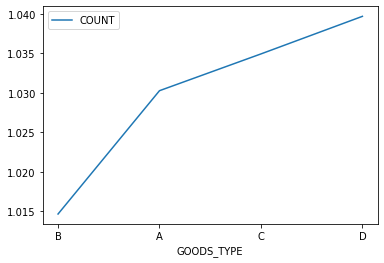

In [47]:
# GOODS_TYPE별 주차시간 평균

tmp = data.groupby("GOODS_TYPE").mean()[["COUNT"]].sort_values('COUNT')
display(tmp)
sns.lineplot(data=tmp)

In [48]:
data.GOODS_TYPE.value_counts()

A    609790
C    131163
B    118541
D     19777
Name: GOODS_TYPE, dtype: int64

In [49]:
# AD1별 주차시간 평균

data.groupby("AD1").mean()[["COUNT"]].sort_values('COUNT')

# AD1은 주차장소와 관련있는 듯

,COUNT
AD1,
GR,1.000000
DOI,1.000000
DSO,1.000000
EP,1.000000
GGC,1.000000
...,...
SOD,1.159613
RRR,1.333333
GPJ,1.580645


In [50]:
data[data.AD1 == 'DY']

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,JOIN_YEAR,JOIN_MONTH,MONTH,WEEKDAY,JOIN_YM
638872,999665,2018-12-16,CC,157711,A,2020-10-08,48,DY,2018,12,10,3,2018-12


In [51]:
data[data.AD1 == 'SJV']

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,JOIN_YEAR,JOIN_MONTH,MONTH,WEEKDAY,JOIN_YM
456966,1617777,2020-07-06,AA,223666,C,2020-07-28,1,SJV,2020,07,07,1,2020-07
462217,1454629,2020-01-01,AA,223666,A,2020-07-30,1,SJV,2020,01,07,3,2020-01
463472,1640932,2020-07-30,AA,223666,A,2020-07-30,1,SJV,2020,07,07,3,2020-07
470698,1383807,2019-11-08,BB,225636,A,2020-08-02,1,SJV,2019,11,08,6,2019-11
474230,1645196,2020-08-03,BB,223666,A,2020-08-03,1,SJV,2020,08,08,0,2020-08
474729,676099,2017-12-17,BB,225636,A,2020-08-04,1,SJV,2017,12,08,1,2017-12
476419,1569535,2020-05-15,AA,223666,A,2020-08-04,1,SJV,2020,05,08,1,2020-05
477005,1644936,2020-08-02,AA,223666,A,2020-08-04,1,SJV,2020,08,08,1,2020-08
482975,110026,2015-06-17,BB,223666,A,2020-08-07,6,SJV,2015,06,08,4,2015-06
507282,1639271,2020-07-28,BB,223666,A,2020-08-15,1,SJV,2020,07,08,5,2020-07


,COUNT
WEEKDAY,
0,1.026721
1,1.027602
3,1.027744
2,1.028340
4,1.028423
6,1.032050
5,1.033663


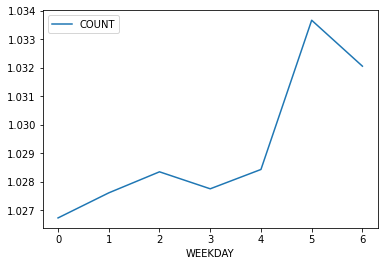

In [52]:
# 요일별 주차시간 평균

tmp = data.groupby("WEEKDAY").mean()[["COUNT"]].sort_values('COUNT')
display(tmp)
sns.lineplot(data=tmp)
# 주말에 더 높음

2. 요일별 이용량 EDA

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,JOIN_YEAR,JOIN_MONTH,MONTH,JOIN_YM
WEEKDAY,,,,,,,,,,,,
0,127052,127052,127052,127052,127052,127052,127052,127052,127052,127052,127052,127052
1,130681,130681,130681,130681,130681,130681,130681,130681,130681,130681,130681,130681
2,132285,132285,132285,132285,132285,132285,132285,132285,132285,132285,132285,132285
3,133616,133616,133616,133616,133616,133616,133616,133616,133616,133616,133616,133616
4,137917,137917,137917,137917,137917,137917,137917,137917,137917,137917,137917,137917
5,131480,131480,131480,131480,131480,131480,131480,131480,131480,131480,131480,131480
6,86240,86240,86240,86240,86240,86240,86240,86240,86240,86240,86240,86240


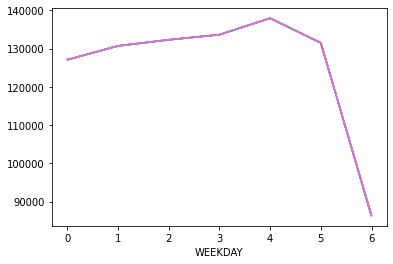

In [53]:
tmp = data.groupby("WEEKDAY").count()
display(tmp)
sns.lineplot(data=tmp, legend=False)
# 주말에 이용시간은 늘었지만(count) 이용건수는 줄었따.

In [54]:
data

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,JOIN_YEAR,JOIN_MONTH,MONTH,WEEKDAY,JOIN_YM
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014,01,01,2,2014-01
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014,02,01,2,2014-02
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014,11,01,2,2014-11
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014,12,01,2,2014-12
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014,12,01,2,2014-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020,12,12,3,2020-12
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020,12,12,3,2020-12
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020,12,12,3,2020-12
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020,12,12,3,2020-12


USER_ID  JOIN_DATE  STORE_ID  ...  JOIN_MONTH  MONTH  JOIN_YM
WEEKDAY D_TYPE                                ...                            
0       AA        71478      71478     71478  ...       71478  71478    71478
        BB        55356      55356     55356  ...       55356  55356    55356
        CC          218        218       218  ...         218    218      218
1       AA        73370      73370     73370  ...       73370  73370    73370
        BB        57076      57076     57076  ...       57076  57076    57076
        CC          235        235       235  ...         235    235      235
2       AA        74038      74038     74038  ...       74038  74038    74038
        BB        58002      58002     58002  ...       58002  58002    58002
        CC          245        245       245  ...         245    245      245
3       AA        75000      75000     75000  ...       75000  75000    75000
        BB        58370      58370     58370  ...       58370  58370    58370
        CC          246        246       246  ...         246    246      246
4       AA        77128      77128     77128  ...       77128  77128    77128
        BB        60527      60527     60527  ...       60527  60527    60527
        CC          262        262       262  ...         262    262      262
5       AA        74747      74747     74747  ...       74747  74747    74747
        BB        56522      56522     56522  ...       56522  56522    56522
        CC          211        211       211  ...         211    211      211
6       AA        47405      47405     47405  ...       47405  47405    47405
        BB        38688      38688     38688  ...       38688  38688    38688
        CC          147        147       147  ...         147    147      147

[21 rows x 11 columns]

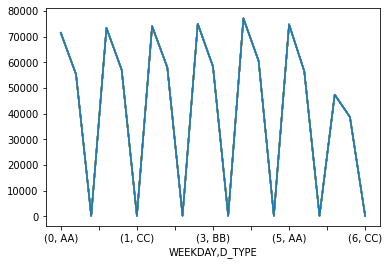

In [55]:
tmp = data.groupby(['WEEKDAY', 'D_TYPE']).count()
display(tmp)
tmp.plot.line(legend=False)

USER_ID  JOIN_DATE  D_TYPE  ...  JOIN_MONTH  MONTH  JOIN_YM
WEEKDAY GOODS_TYPE                              ...                            
0       A             89099      89099   89099  ...       89099  89099    89099
        B             16993      16993   16993  ...       16993  16993    16993
        C             16733      16733   16733  ...       16733  16733    16733
        D              4227       4227    4227  ...        4227   4227     4227
1       A             89400      89400   89400  ...       89400  89400    89400
        B             20744      20744   20744  ...       20744  20744    20744
        C             17489      17489   17489  ...       17489  17489    17489
        D              3048       3048    3048  ...        3048   3048     3048
2       A             89360      89360   89360  ...       89360  89360    89360
        B             21586      21586   21586  ...       21586  21586    21586
        C             18231      18231   18231  ...       18231  18231    18231
        D              3108       3108    3108  ...        3108   3108     3108
3       A             89246      89246   89246  ...       89246  89246    89246
        B             22793      22793   22793  ...       22793  22793    22793
        C             18291      18291   18291  ...       18291  18291    18291
        D              3286       3286    3286  ...        3286   3286     3286
4       A             86662      86662   86662  ...       86662  86662    86662
        B             27847      27847   27847  ...       27847  27847    27847
        C             19913      19913   19913  ...       19913  19913    19913
        D              3495       3495    3495  ...        3495   3495     3495
5       A             99048      99048   99048  ...       99048  99048    99048
        B              6218       6218    6218  ...        6218   6218     6218
        C             24413      24413   24413  ...       24413  24413    24413
        D              1801       1801    1801  ...        1801   1801     1801
6       A             66975      66975   66975  ...       66975  66975    66975
        B              2360       2360    2360  ...        2360   2360     2360
        C             16093      16093   16093  ...       16093  16093    16093
        D               812        812     812  ...         812    812      812

[28 rows x 11 columns]

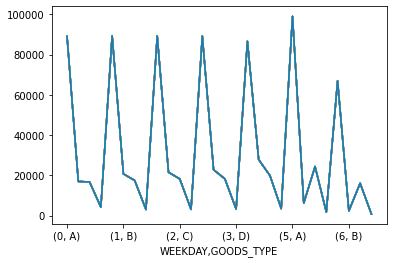

In [56]:
tmp = data.groupby(['WEEKDAY', 'GOODS_TYPE']).count()
display(tmp)
tmp.plot.line(legend=False)

# 주말 B타입이 많이 줄었따.

USER_ID  JOIN_DATE  D_TYPE  ...  JOIN_MONTH  MONTH  JOIN_YM
WEEKDAY AD1                              ...                            
0       0        727        727     727  ...         727    727      727
        ABP       23         23      23  ...          23     23       23
        AOI        4          4       4  ...           4      4        4
        BF      2028       2028    2028  ...        2028   2028     2028
        BHW       11         11      11  ...          11     11       11
...              ...        ...     ...  ...         ...    ...      ...
6       YC       164        164     164  ...         164    164      164
        YD      4122       4122    4122  ...        4122   4122     4122
        YO      2972       2972    2972  ...        2972   2972     2972
        ZE        40         40      40  ...          40     40       40
        ZP         3          3       3  ...           3      3        3

[534 rows x 11 columns]

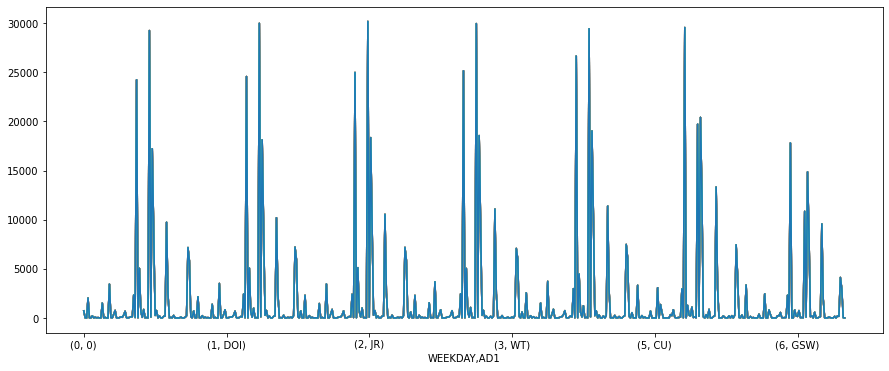

In [57]:
tmp = data.groupby(['WEEKDAY', 'AD1']).count()
display(tmp)

tmp.plot.line(legend=False, figsize = (15, 6))

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 50836 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51068 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 50836 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 51068 missing from current font.



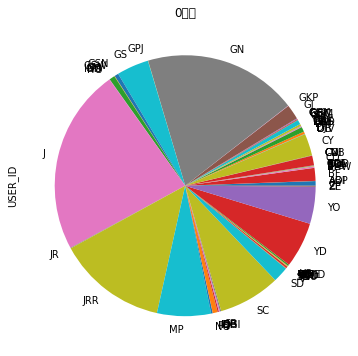

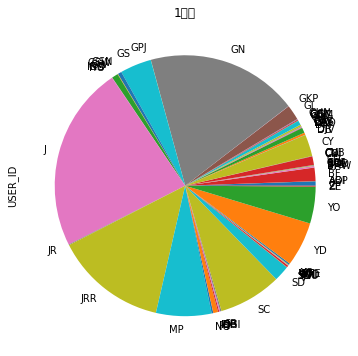

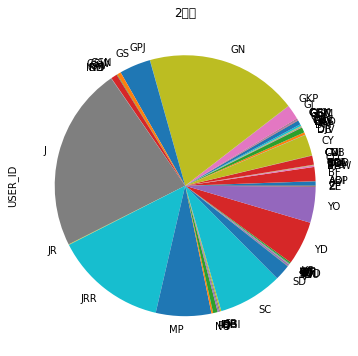

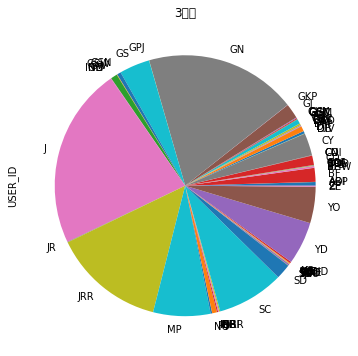

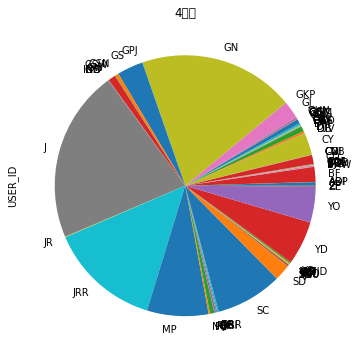

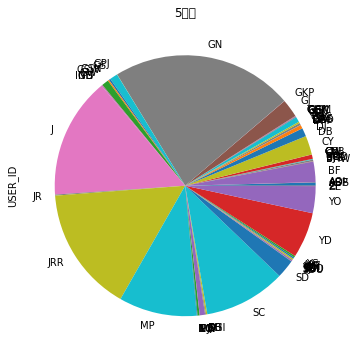

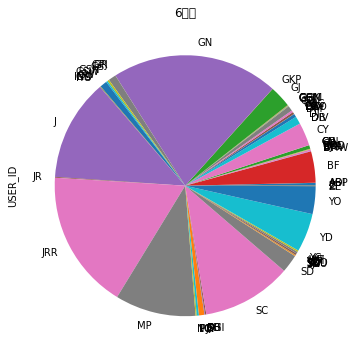

In [58]:
for i in range(7):
    data[data.WEEKDAY == i].groupby('AD1').count().plot.pie(y='USER_ID', legend=False, figsize=(10,6), title = str(i)+'요일')
    
# 주말이 되면서 JRR, MP, SC의 분포가 늘어났다.

# COUNT에 영향을 주는 요소

    * 요일
    * D_TYPE
    * GOODS_TYPE
    * AD1

In [59]:
data

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,JOIN_YEAR,JOIN_MONTH,MONTH,WEEKDAY,JOIN_YM
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014,01,01,2,2014-01
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014,02,01,2,2014-02
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014,11,01,2,2014-11
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014,12,01,2,2014-12
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014,12,01,2,2014-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020,12,12,3,2020-12
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020,12,12,3,2020-12
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020,12,12,3,2020-12
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020,12,12,3,2020-12


In [60]:
train = data[data["DATE"] < "2020-10-01"]
test = data[data["DATE"] >= "2020-10-01"]

In [61]:
print(len(train))
print(len(test))

623579
255692


In [61]:
!pip install pycaret

     |████████████████████████████████| 264 kB 4.3 MB/s 
     |████████████████████████████████| 167 kB 42.8 MB/s 
     |████████████████████████████████| 248 kB 43.6 MB/s 
     |████████████████████████████████| 108 kB 53.1 MB/s 
     |████████████████████████████████| 14.4 MB 63 kB/s 
     |████████████████████████████████| 6.8 MB 39.7 MB/s 
     |████████████████████████████████| 1.7 MB 53.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 80 kB 9.1 MB/s 
     |████████████████████████████████| 1.3 MB 38.8 MB/s 
     |████████████████████████████████| 271 kB 44.9 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 2.0 MB 35.6 MB/s 
     |████████████████████████████████| 636 kB 32.7 MB/s 
     |████████████████████████████████| 10.1 MB 33.3 MB/s 
     |██████████████████

In [62]:
from pycaret.regression import *
reg = setup(data = train, test_data = test, target='COUNT', session_id=123, log_experiment=True, experiment_name='reg1', train_size=1.0)

,Description,Value
0,session_id,123
1,Target,COUNT
2,Original Data,"(623579, 13)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,7
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(623579, 142)"


In [63]:
best_model = compare_models(fold=5, exclude=['rf','et'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0403,0.0522,0.2267,0.6848,0.0610,0.0276,4.678
lar,Least Angle Regression,0.0442,0.0917,0.2970,0.4762,0.0655,0.0304,0.988
br,Bayesian Ridge,0.0445,0.0916,0.2970,0.4761,0.0655,0.0308,18.156
omp,Orthogonal Matching Pursuit,0.0433,0.0917,0.2970,0.4758,0.0654,0.0295,0.960
ridge,Ridge Regression,0.0498,0.0923,0.2976,0.4755,0.0666,0.0360,0.790
knn,K Neighbors Regressor,0.0393,0.1111,0.3297,0.3489,0.0716,0.0260,31.140
dt,Decision Tree Regressor,0.0413,0.1199,0.3437,0.2160,0.0826,0.0271,9.460
lasso,Lasso Regression,0.0531,0.1817,0.4174,-0.0001,0.0760,0.0354,0.754
en,Elastic Net,0.0531,0.1817,0.4174,-0.0001,0.0760,0.0354,0.746
llar,Lasso Least Angle Regression,0.0531,0.1817,0.4174,-0.0001,0.0760,0.0354,0.952


In [65]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0388,0.0530,0.2303,0.6367,0.0584,0.0266
1,0.0392,0.0428,0.2068,0.5302,0.0619,0.0264
2,0.0368,0.0283,0.1682,0.6964,0.0551,0.0267
3,0.0376,0.0379,0.1946,0.6826,0.0575,0.0265
4,0.0389,0.0323,0.1796,0.7471,0.0602,0.0274
5,0.0388,0.0454,0.2132,0.7165,0.0583,0.0271
6,0.0410,0.0456,0.2134,0.7919,0.0611,0.0294
7,0.0413,0.0476,0.2183,0.8176,0.0633,0.0285
8,0.0427,0.0586,0.2421,0.7869,0.0635,0.0292
9,0.0487,0.1153,0.3395,0.6446,0.0688,0.0311


In [68]:
tuned_lightgbm = tune_model(lightgbm, n_iter=10, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0404,0.0648,0.2545,0.5563,0.0594,0.0271
1,0.0421,0.0685,0.2617,0.2476,0.0635,0.0276
2,0.0383,0.0396,0.1990,0.5751,0.0560,0.0271
3,0.0392,0.0449,0.2119,0.6237,0.0584,0.0272
4,0.0398,0.0353,0.1879,0.7234,0.0612,0.0278
5,0.0393,0.0473,0.2175,0.7049,0.0598,0.0275
6,0.0413,0.0575,0.2397,0.7375,0.0595,0.0287
7,0.0437,0.0751,0.2740,0.7126,0.0637,0.0289
8,0.0448,0.0784,0.2800,0.7149,0.0640,0.0300
9,0.0479,0.1146,0.3385,0.6466,0.0694,0.0301


In [69]:
tuned_lightgbm

LGBMRegressor(bagging_fraction=0.6, bagging_freq=4, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=96, min_child_weight=0.001, min_split_gain=0.7,
              n_estimators=180, n_jobs=-1, num_leaves=10, objective=None,
              random_state=123, reg_alpha=0.0001, reg_lambda=0.1, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [70]:
ridge = create_model('ridge')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1415,0.1040,0.3224,0.2877,0.0861,0.1297
1,0.0395,0.0822,0.2866,0.0971,0.0683,0.0261
2,0.0378,0.0286,0.1692,0.6929,0.0556,0.0278
3,0.0382,0.0480,0.2190,0.5980,0.0600,0.0269
4,0.0447,0.0772,0.2778,0.3950,0.0684,0.0327
5,0.0450,0.0767,0.2770,0.5215,0.0646,0.0330
6,0.0478,0.0912,0.3020,0.5836,0.0630,0.0343
7,0.0486,0.1104,0.3323,0.5772,0.0663,0.0325
8,0.0502,0.1129,0.3359,0.5898,0.0673,0.0343
9,0.0530,0.1640,0.4050,0.4941,0.0746,0.0338


In [79]:
bagged_ridge = ensemble_model(ridge, n_estimators=50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0404,0.0907,0.3012,0.3786,0.0654,0.0277
1,0.0393,0.0817,0.2859,0.1021,0.0682,0.0259
2,0.0378,0.0286,0.1692,0.6931,0.0556,0.0278
3,0.0382,0.0480,0.2190,0.5978,0.0600,0.0269
4,0.0446,0.0774,0.2783,0.3931,0.0684,0.0326
5,0.0451,0.0767,0.2770,0.5214,0.0646,0.0331
6,0.0478,0.0909,0.3015,0.5848,0.0631,0.0343
7,0.0486,0.1102,0.3320,0.5779,0.0663,0.0325
8,0.0502,0.1135,0.3368,0.5876,0.0673,0.0342
9,0.0528,0.1651,0.4064,0.4908,0.0746,0.0336


In [80]:
boosted_ridge = ensemble_model(ridge, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.2737,0.2245,0.4738,-0.5382,0.2074,0.2595
1,0.3223,0.3241,0.5693,-2.5614,0.2254,0.3053
2,0.2553,0.1944,0.4409,-1.0845,0.1813,0.2422
3,0.2507,0.2029,0.4505,-0.7011,0.1801,0.2373
4,0.2342,0.1986,0.4456,-0.5563,0.1667,0.2209
5,0.2136,0.1779,0.4218,-0.1098,0.1512,0.2013
6,0.2106,0.1441,0.3796,0.3418,0.1509,0.1989
7,0.2910,0.2109,0.4593,0.1923,0.1775,0.2793
8,0.3870,0.3368,0.5804,-0.2244,0.2265,0.3753
9,0.1924,0.1768,0.4204,0.4549,0.1435,0.1753


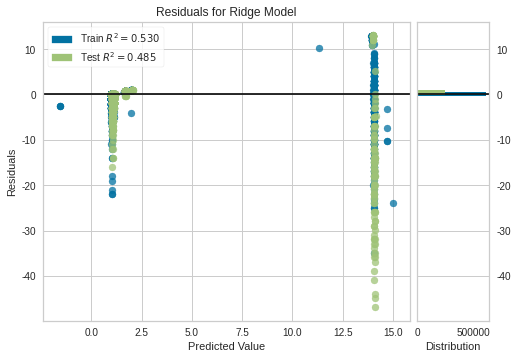

In [73]:
plot_model(ridge)

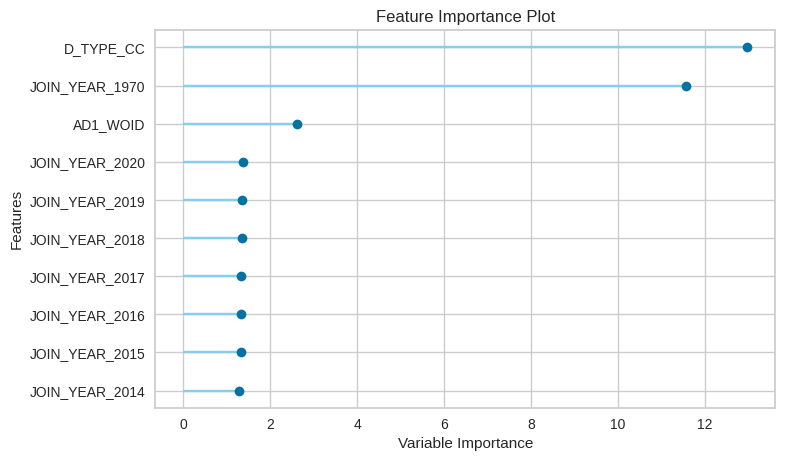

In [74]:
plot_model(ridge, plot = 'feature')

In [75]:
pred_holdouts = predict_model(lightgbm)
pred_holdouts.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0492,0.209,0.4572,0.5454,0.0677,0.03


,USER_ID,STORE_ID,D_TYPE_AA,D_TYPE_CC,GOODS_TYPE_A,GOODS_TYPE_B,GOODS_TYPE_C,GOODS_TYPE_D,AD1_0,AD1_ABP,AD1_AOI,AD1_BF,AD1_BHW,AD1_BI,AD1_BJG,AD1_BO,AD1_BOI,AD1_BP,AD1_BUD,AD1_CAS,AD1_CCA,AD1_CD,AD1_CN,AD1_COI,AD1_CU,AD1_CY,AD1_DB,AD1_DIV,AD1_DJ,AD1_DM,AD1_DOI,AD1_DSO,AD1_EP,AD1_GAS,AD1_GAY,AD1_GB,AD1_GBC,AD1_GD,AD1_GEJ,AD1_GGC,...,WEEKDAY_2,WEEKDAY_5,JOIN_DATE_month_1,JOIN_DATE_month_4,JOIN_DATE_month_7,JOIN_DATE_month_8,JOIN_DATE_weekday_0,JOIN_DATE_weekday_1,JOIN_DATE_weekday_2,JOIN_DATE_weekday_3,JOIN_DATE_weekday_4,JOIN_DATE_weekday_5,JOIN_DATE_weekday_6,JOIN_DATE_is_month_end_0,JOIN_DATE_is_month_start_0,DATE_month_1,DATE_month_2,DATE_month_4,DATE_month_5,DATE_month_9,DATE_weekday_0,DATE_weekday_3,DATE_weekday_4,DATE_weekday_6,DATE_is_month_end_0,DATE_is_month_start_1,JOIN_YM_month_10,JOIN_YM_month_12,JOIN_YM_month_5,JOIN_YM_weekday_0,JOIN_YM_weekday_1,JOIN_YM_weekday_2,JOIN_YM_weekday_3,JOIN_YM_weekday_4,JOIN_YM_weekday_5,JOIN_YM_weekday_6,JOIN_YM_is_month_end_0,JOIN_YM_is_month_start_1,COUNT,Label
0,15521.0,182320.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.015802
1,17651.0,82434.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.017065
2,26388.0,182320.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.014905
3,81772.0,204438.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.013824
4,92258.0,220745.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.018169


In [76]:
pred_holdouts = predict_model(ridge)
pred_holdouts.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.0846,0.237,0.4868,0.4846,0.0736,0.0655


,USER_ID,STORE_ID,D_TYPE_AA,D_TYPE_CC,GOODS_TYPE_A,GOODS_TYPE_B,GOODS_TYPE_C,GOODS_TYPE_D,AD1_0,AD1_ABP,AD1_AOI,AD1_BF,AD1_BHW,AD1_BI,AD1_BJG,AD1_BO,AD1_BOI,AD1_BP,AD1_BUD,AD1_CAS,AD1_CCA,AD1_CD,AD1_CN,AD1_COI,AD1_CU,AD1_CY,AD1_DB,AD1_DIV,AD1_DJ,AD1_DM,AD1_DOI,AD1_DSO,AD1_EP,AD1_GAS,AD1_GAY,AD1_GB,AD1_GBC,AD1_GD,AD1_GEJ,AD1_GGC,...,WEEKDAY_2,WEEKDAY_5,JOIN_DATE_month_1,JOIN_DATE_month_4,JOIN_DATE_month_7,JOIN_DATE_month_8,JOIN_DATE_weekday_0,JOIN_DATE_weekday_1,JOIN_DATE_weekday_2,JOIN_DATE_weekday_3,JOIN_DATE_weekday_4,JOIN_DATE_weekday_5,JOIN_DATE_weekday_6,JOIN_DATE_is_month_end_0,JOIN_DATE_is_month_start_0,DATE_month_1,DATE_month_2,DATE_month_4,DATE_month_5,DATE_month_9,DATE_weekday_0,DATE_weekday_3,DATE_weekday_4,DATE_weekday_6,DATE_is_month_end_0,DATE_is_month_start_1,JOIN_YM_month_10,JOIN_YM_month_12,JOIN_YM_month_5,JOIN_YM_weekday_0,JOIN_YM_weekday_1,JOIN_YM_weekday_2,JOIN_YM_weekday_3,JOIN_YM_weekday_4,JOIN_YM_weekday_5,JOIN_YM_weekday_6,JOIN_YM_is_month_end_0,JOIN_YM_is_month_start_1,COUNT,Label
0,15521.0,182320.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.031734
1,17651.0,82434.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.031326
2,26388.0,182320.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.045883
3,81772.0,204438.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.041326
4,92258.0,220745.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.067137


In [81]:
pred_holdouts = predict_model(boosted_ridge)
pred_holdouts.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.1349,0.3672,0.606,0.2013,0.1175,0.1147


,USER_ID,STORE_ID,D_TYPE_AA,D_TYPE_CC,GOODS_TYPE_A,GOODS_TYPE_B,GOODS_TYPE_C,GOODS_TYPE_D,AD1_0,AD1_ABP,AD1_AOI,AD1_BF,AD1_BHW,AD1_BI,AD1_BJG,AD1_BO,AD1_BOI,AD1_BP,AD1_BUD,AD1_CAS,AD1_CCA,AD1_CD,AD1_CN,AD1_COI,AD1_CU,AD1_CY,AD1_DB,AD1_DIV,AD1_DJ,AD1_DM,AD1_DOI,AD1_DSO,AD1_EP,AD1_GAS,AD1_GAY,AD1_GB,AD1_GBC,AD1_GD,AD1_GEJ,AD1_GGC,...,WEEKDAY_2,WEEKDAY_5,JOIN_DATE_month_1,JOIN_DATE_month_4,JOIN_DATE_month_7,JOIN_DATE_month_8,JOIN_DATE_weekday_0,JOIN_DATE_weekday_1,JOIN_DATE_weekday_2,JOIN_DATE_weekday_3,JOIN_DATE_weekday_4,JOIN_DATE_weekday_5,JOIN_DATE_weekday_6,JOIN_DATE_is_month_end_0,JOIN_DATE_is_month_start_0,DATE_month_1,DATE_month_2,DATE_month_4,DATE_month_5,DATE_month_9,DATE_weekday_0,DATE_weekday_3,DATE_weekday_4,DATE_weekday_6,DATE_is_month_end_0,DATE_is_month_start_1,JOIN_YM_month_10,JOIN_YM_month_12,JOIN_YM_month_5,JOIN_YM_weekday_0,JOIN_YM_weekday_1,JOIN_YM_weekday_2,JOIN_YM_weekday_3,JOIN_YM_weekday_4,JOIN_YM_weekday_5,JOIN_YM_weekday_6,JOIN_YM_is_month_end_0,JOIN_YM_is_month_start_1,COUNT,Label
0,15521.0,182320.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.957230
1,17651.0,82434.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,-1.452613
2,26388.0,182320.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.970886
3,81772.0,204438.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.966735
4,92258.0,220745.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.991317
